In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
fake_data = pd.read_csv('C:/Users/Windows10/Desktop/Python/data/fake_news/Fake.csv')
true_data = pd.read_csv('C:/Users/Windows10/Desktop/Python/data/fake_news/True.csv')

In [3]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_data['target'] = 0
true_data['target'] = 1

print(fake_data.head())
print('-'*20)
print(true_data.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  target  
0  December 31, 2017       0  
1  December 31, 2017       0  
2  December 30, 2017       0  
3  December 29, 2017       0  
4  December 25, 2017       0  
--------------------
                                               title  \
0  As U.S. budg

In [6]:
df = pd.concat([true_data, fake_data])
df

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [7]:
df = df.drop(['subject', 'date'], axis = 1)
df['text_'] = df['title'] + ' ' + df['text']
df = df.drop(['title', 'text'], axis = 1)

df.head()

,target,text_
0,1,"As U.S. budget fight looms, Republicans flip t..."
1,1,U.S. military to accept transgender recruits o...
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,1,FBI Russia probe helped by Australian diplomat...
4,1,Trump wants Postal Service to charge 'much mor...


In [8]:
df = df[['text_', 'target']]
df.head()

,text_,target
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [9]:
df_shuffled = df.sample(frac = 1).reset_index(drop = True)

In [10]:
train_split = int(len(df_shuffled) * 0.75)

x_train = df_shuffled['text_'][:train_split]
x_test = df_shuffled['text_'][train_split:]

y_train = df_shuffled['target'][:train_split]
y_test = df_shuffled['target'][train_split:]

In [11]:
t = Tokenizer(num_words= 10000, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', lower = True, split = ' ')
t.fit_on_texts(x_train)
x_train_seq = t.texts_to_sequences(x_train)
x_test_seq = t.texts_to_sequences(x_test)


In [12]:
x_train_chunk = pad_sequences(x_train_seq, maxlen = 200)
x_test_chunk = pad_sequences(x_test_seq, maxlen = 200)

In [13]:
model = Sequential([
    Embedding(len(t.word_index) + 1, 32, input_length= 200),
    LSTM(64, activation= 'tanh'),
    Dense(32, activation= 'relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [14]:
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics= ['acc'])
es = EarlyStopping(monitor= 'val_loss', patience= 5)

In [15]:
history = model.fit(x_train_chunk, y_train, epochs = 200, batch_size = 64, validation_split= 0.2, callbacks= [es])

Epoch 1/200
421/421 [==============================] - 68s 155ms/step - loss: 0.1290 - acc: 0.9547 - val_loss: 0.0432 - val_acc: 0.9852
Epoch 2/200
421/421 [==============================] - 66s 158ms/step - loss: 0.0354 - acc: 0.9903 - val_loss: 0.0357 - val_acc: 0.9892
Epoch 3/200
421/421 [==============================] - 67s 158ms/step - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0380 - val_acc: 0.9887
Epoch 4/200
421/421 [==============================] - 65s 155ms/step - loss: 0.0193 - acc: 0.9952 - val_loss: 0.0368 - val_acc: 0.9898
Epoch 5/200
421/421 [==============================] - 65s 155ms/step - loss: 0.0147 - acc: 0.9963 - val_loss: 0.0377 - val_acc: 0.9895
Epoch 6/200
421/421 [==============================] - 69s 165ms/step - loss: 0.0118 - acc: 0.9967 - val_loss: 0.0581 - val_acc: 0.9893
Epoch 7/200
421/421 [==============================] - 65s 155ms/step - loss: 0.0094 - acc: 0.9975 - val_loss: 0.0375 - val_acc: 0.9889


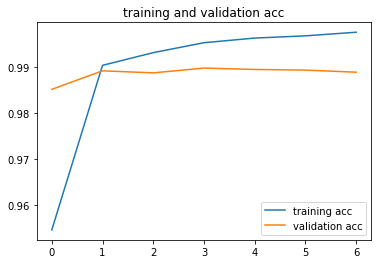

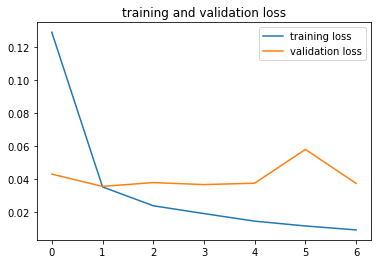

In [16]:
hist = history.history

epochs = range(len(hist['acc']))

plt.figure()
plt.plot(epochs, hist['acc'], label = 'training acc')
plt.plot(epochs, hist['val_acc'], label = 'validation acc')
plt.title('training and validation acc')
plt.legend()

plt.figure()
plt.plot(epochs, hist['loss'], label = 'training loss')
plt.plot(epochs, hist['val_loss'], label = 'validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [17]:
model.evaluate(x_test_chunk, y_test)

351/351 [==============================] - 10s 29ms/step - loss: 0.0281 - acc: 0.9914 1


[0.02812202088534832, 0.9914476871490479]

In [18]:
y_pred = model.predict(x_test_chunk)

In [19]:
print(y_pred)

[[9.9999422e-01]
 [9.5382120e-06]
 [2.6986262e-07]
 ...
 [4.2607558e-06]
 [6.0319418e-01]
 [5.1481888e-06]]


In [24]:
data =tf.keras.utils.get_file(fname = 'cnn.txt', origin = 'http://lite.cnn.com/en/article/h_9400d057230ca40965919245762ecb26')
f = open(data, 'r')
all_text = f.read()
f.close()

all_text_ = re.sub('[^a-zA-Z0-9]', ' ', all_text)

In [34]:
all_text_[:500]

'  DOCTYPE HTML PUBLIC     W3C  DTD HTML 4 01 Transitional  EN    html  head  meta http equiv  Content Type  content  text html  charset UTF 8    meta name  viewport  content  width device width  initial scale 1    link type  text css  rel  stylesheet  href   static main 650c7b8fbdce6a28161cf1157d8d5800 css    title data react helmet  true  CNN   Breaking News  Latest News and Videos  title  meta data react helmet  true  name  description  content  View the latest news and breaking news today for'

In [36]:
all_text_seq = t.texts_to_sequences(all_text_)
all_text_seq = sum(all_text_seq, [])

In [27]:
all_text_chunk = all_text_seq[:200]

In [28]:
all_text_chunk = np.array(all_text_chunk)

In [30]:
all_text_chunk = np.reshape(all_text_chunk, (1, 200))

In [31]:
all_text_chunk

array([[ 338,  915, 1234,   40, 4835, 1511, 1614, 1762,   40,  298, 3470,
        1511,   33, 2013, 3470,   34, 1234, 1103,  323, 1234,  338,   40,
         338, 1762,   40,  298, 3470,  404, 1799,  195,   40, 1081,    4,
         340,    8,   34,   40,   34,  915,  340,    4, 3470, 1614,  340,
        1762,   40,  298, 3470, 1762, 1614,    4,  338,  298, 1614,   40,
           4, 1762,   40,   40, 1511, 1614, 6123,   33,   34, 1832, 1234,
         915,  340,   40, 1614,  340,   40,   40, 4835, 1511, 1614, 1234,
         915,  340,   40, 1614,  340,   40,   40, 1614, 5717,   40, 1762,
          40,  298, 3470, 1234, 1762,    4, 1081,    8, 1614,   40,   33,
          40, 1175,  406,  298, 1614,   40,    4,  340,    4,  298, 1614,
        1832,   34, 1614, 1103, 1511,  915, 1081,   40, 1234,  915,  340,
          40, 1614,  340,   40, 1103,   34,  338,   40, 1762,  338, 1614,
        1832,   34, 1234, 1614, 1103,   34,  338,   40, 1762,   34,  340,
          34,   40,   34,    4, 3470, 

In [32]:
model.predict(all_text_chunk)

array([[0.00301066]], dtype=float32)

In [51]:
import random
num_box = []
def random_data_output(data_num):
    for i in range(data_num):
        r1 = random.randint(0, 1)
        r2 = random.randint(0, 11000)
        print(r2)
            
        if r1 == 0:
            data = x_train_chunk[r2]
            text = x_train[r2]
        elif r2 == 1:
            data = x_test_chunk[r2]
            text = x_test[r2]
        data_ = np.reshape(data, (1, 200))
        pred = model.predict(data_)
        print(text[:200])
        if np.round(pred) == 0:
            print('이 기사는 가짜 기사입니다.')
        elif np.round(pred) == 1:
            print('이 기사는 진짜 기사입니다.')
        print('-'*20)
        
        

In [52]:
random_data_output(10)

9334
FLASHBACK: KEY DEMOCRATS Call for Violence in the Streets…”March, Bleed, Die” [Video] And we wonder why violence like today s shooting happened The left started with the violence during the 2016 and c
이 기사는 가짜 기사입니다.
--------------------
5179
Czech election winner Babis calls minority government 'unrealistic' LANY, Czech Republic (Reuters) - Czech billionaire Andrej Babis, the runaway winner of last weekend s parliamentary election, said o
이 기사는 진짜 기사입니다.
--------------------
6185
Czech election winner Babis calls minority government 'unrealistic' LANY, Czech Republic (Reuters) - Czech billionaire Andrej Babis, the runaway winner of last weekend s parliamentary election, said o
이 기사는 진짜 기사입니다.
--------------------
6040
TRUMP SAYS “YES” To Federal Funding For Planned Parenthood…Under One Condition…And You’re Gonna Love It! Sounds like a great deal, right? After all, Planned Parenthood insists that only 3% of its busi
이 기사는 가짜 기사입니다.
--------------------
161
TRUMP SAYS “YES” To Fede